# Table of Contents
---

### 1. [**Goal of this Lab**](#section:goal)

### 2. [**Preliminaries**](#section:preliminaries)

### 3. [**Part 1: Model Architecture**](#section:model_arch)
*   #### [**Encoder & Decoder Blocks**](#section:encoder_decoder)
*   #### [**MLP**](#section:mlp)
*   #### [**Attention**](#section:attention)
*   #### [**Embeddings**](#section:embeddings)
*   #### [**Positional Encoding**](#section:pos_enc)
*   #### [**Full Model**](#section:model)
*   #### [**Example Inference**](#section:example_inference)

### 4. [**Part 2: Model Training**](#section:model_training)


### 5. [**Part 3: A First Example: Learning to Copy**](#section:first_example)


### 6. [**Part 4: Translating Spanish to Aragonese**](#section:translation)
* #### [**Dataset Preparation**](#section:es_an_dataset)
* #### [**Train a Model From Scratch**](#section:train_from_scratch)
* #### [**Evaluate a Model Trained From Scratch**](#section:eval_from_scratch)
* #### [**Finetune a Pretrained Transformer**](#section:train_mt5)
* #### [**Evaluate a Finetuned Model**](#section:eval_mt5)
* #### [**Attention Visualization**](#section:attention_visualization)

### 7. [**Part 5: Translating Idiomatic Sentences**](#section:idiomatic)

### 8. [**Conclusion**](#section:conclusion)

### 9. [**Acknowledgements**](#section:acknowledgements)



<a name="section:goal"></a>
# Goal of this Lab

Transformers are the backbone of most existing state-of-the-art models for Natural Language Processing, like Chat-GPT, Gemini, Llama often called as Large Language Models (LLMs) as they model the sequence of words, letters, or tokens in general, and learn how words follow each other. When training LLMs, we try to predict the next word (or token in a sequence). We give at the input a sequence and all it does is complete it with the outcome.


---
Transformers were introduced in 2017 with the paper [Attention is All you Need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).




This paper reads like a standard machine translation paper. However, over the following years, transformers ended up taking over all of other Artificial Intelligence (AI) fields ([computer vision](https://proceedings.mlr.press/v139/radford21a), [audio processing](https://scontent.fath4-2.fna.fbcdn.net/v/t39.2365-6/406941874_247486308347770_2317832131512763077_n.pdf?_nc_cat=102&ccb=1-7&_nc_sid=3c67a6&_nc_ohc=hzLHysYvyscQ7kNvgG632q4&_nc_ht=scontent.fath4-2.fna&_nc_gid=Acqsypm_wc2ArPN_j-I53Yw&oh=00_AYCfXJA0aKFkpaA4IGyCThixjpWHwg6nnElq7n35HhnUjA&oe=66EED669), [video processing](https://proceedings.mlr.press/v139/bertasius21a/bertasius21a.pdf), etc). This architecture was basically copy-pasted with very minor modifications into basically all AI applications.


---
**<ins>What we are going to do in the lab</ins>**


Our goal in this lab is to understand how the transformer work.
What is the neural network under the hood that learns to model the sequence of this words?


The architecture of the vanilla transformer is shown in the next figure. The initial transformer is composed of an encoder and a decoder, where each module has multiple layers. Each of these layers is equipped with the attention mechanism, layer normalization and multi-layer perceptrons (MLPs).


We are going to build the basic blocks of the vanilla transformer line by line and train a model on an exemplary task (learning to copy the input to the output), as well as a real-world example where we focus on translating sentences from one language (Spanish) to another very-low resource language (Aragonese). The objective of this lab is for you to get a deep understanding of how the transformer works with hands-on experience. Finally, you will interact with [Aya](https://arxiv.org/abs/2402.07827) a state-of-the-art multilingual model and inspect predictions when translating sentences containing an idiom or a metaphorical multi-word expression.


More specifically the lab is split into 5 parts:


* Part 1 includes a walkthrough of the Transformer architecture, where you will be asked to implement the attention mechanism (do not worry, we provide you with step-by-step instructions and you are also encouraged to ask for clarifications).
* Part 2 adds all the necessary components to train a model using pure pytorch code without any external libraries.
* Part 3 introduces a toy copying task to inspect how the model trains.
* Part 4 we train and evaluate a model from scratch to translate sentences from Spanish to Aragonese. We also finetune a pretrained model with a similar architecture on the same task.
* Part 5 encourages collaboration between your fellow students, where you will inspect how a state-of-the-art Transformer addresses figurative language.






**<ins>What we are not going to do in the lab</ins>**


Of course we are not not going to build something like ChatGPT, or Gemini. These are production systems and their network is trained on a significant proportion of the entire internet with multiple training stages that complicate the model development.

<a name="section:preliminaries"></a>
# Prelimaries

Lets install dependencies here

In [ ]:
!pip install datasets evaluate sacrebleu tokenizers altair bertviz

Import libraries that we want to use throughout the lab

In [ ]:
import json
import math
import os
from collections.abc import Iterable
from pathlib import Path
from typing import Literal

import altair as alt
import datasets
import evaluate
import pandas as pd
import tokenizers
import torch
import transformers
from torch import nn
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    PreTrainedModel,
    PreTrainedTokenizerFast,
)


RUN_EXAMPLES = True

In [ ]:
def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)

def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


<a name="section:model_arch"></a>
# Model Architecture

As we already mentioned, the original Transformer model follows an encoder-decoder structure where the encoder and decoder are show in the left and right halves of the figure below.

Here, the encoder maps an input sequence of symbols (tokens) $\mathbf{x} = (x_1, x_2, \dots, x_n)$, to a sequence of continuous representations $\mathbf{z} = (z_1, z_2, \dots, z_n)$. $\mathbf{z}$ is a latent representation of our input sequence that is given to the decoder in order to complete it.

In other words, given $\mathbf{z}$, the decoder generates an output sequence of symbols $\mathbf{y} = (y_1, y_2, \dots y_m)$, one symbol at a time. Each time the model produces an output $y_i$, this symbol is appended at the input in order to generate the next symbol $y_{i+1}$. These models that use their previously generated input to produce the next one are called auto-regressive.


<div align="center">

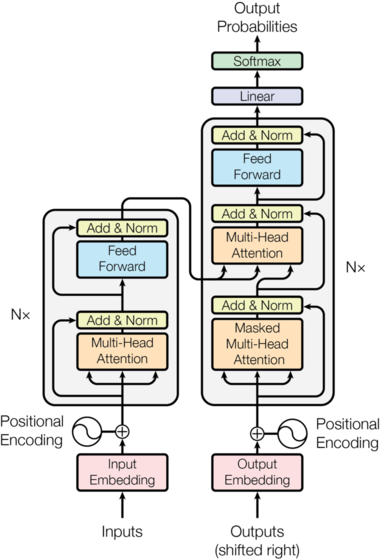

The encoder-decoder is composed of Transformer blocks and follows the architecture shown in the above figure. Each block uses the attention operation and feedforward network (MLPs) for both the encoder and the decoder shown in the left and right halves of the figure.


The encoder accepts a source sequence of integer tokens and embeds it and adds positional information. At each layer, the representations of each token are updated using the attention and the MLP block.


The model as a whole predicts the next word (or token) in the sequence. Thus, the input of the decoder is the expected output sequence shifted by one position to the right. The decoder also embeds the discrete tokens and uses positional information. The main difference here is that each decoder block also employs cross-attention, i.e, the input of the decoder attends to the encoder's output. We will explain each module separately in the sections below.

In [ ]:
class EncoderDecoder(nn.Module):
    """Encoder-Decoder model."""

    def __init__(
        self,
        src_vocab: int,
        tgt_vocab: int,
        num_layers: int = 6,
        d_model: int = 512,
        intermediate_size: int = 2048,
        num_heads: int = 8,
        dropout: int = 0.1,
        attention_dropout: int = 0.1,
        sharable_embeddings: bool = False,
    ) -> None:
        super().__init__()
        """
        Args:
            src_vocab (int): Source vocabulary size
            tgt_vocab (int): Target vocabulary size
            num_layers (int, optional): Number of layers in the encoder and decoder. Defaults to 6.
            d_model (int, optional): Dimension of the model. Defaults to 512.
            intermediate_size (int, optional): Dimension of the feedforward network model. Defaults
            to 2048.
            num_heads (int, optional): Number of attention heads. Defaults to 8.
            dropout (int, optional): Dropout rate. Defaults to 0.1.
            attention_dropout (int, optional): Dropout rate for attention. Defaults to 0.1.
            sharable_embeddings (bool, optional): Whether to share the embeddings between the
            source and target. Defaults to False.
        """

        # Step 1: Create the encoder stack, a series of transformer blocks that process the input
        self.encoder = Encoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            intermediate_size=intermediate_size,
            dropout=dropout,
            attention_dropout=attention_dropout,
        )

        # Step 2: Create the decoder stack, a series of transformer blocks that use the encoder's
        # output to predict the next token in the target sequence
        self.decoder = Decoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            intermediate_size=intermediate_size,
            dropout=dropout,
            attention_dropout=attention_dropout,
        )

        # Step 3: Create the language model head, a linear layer that outputs the logits (i.e, the
        # unnormalized probabilties for each token in the target sequence
        self.lm_head = nn.Linear(d_model, tgt_vocab)

        # Step 4: Create the source and target embeddings, and apply positional encoding to them
        self.src_embed = nn.Sequential(
            Embeddings(d_model, src_vocab), PositionalEncoding(d_model, dropout)
        )
        if sharable_embeddings:
            msg = (
                "When sharing the embeddings, the source and target vocabularies must be the same."
            )
            assert src_vocab == tgt_vocab, msg
            self.tgt_embed = self.src_embed
        else:
            self.tgt_embed = nn.Sequential(
                Embeddings(d_model, tgt_vocab), PositionalEncoding(d_model, dropout)
            )

    def forward(
        self,
        src: torch.Tensor,
        tgt: torch.Tensor,
        src_mask: torch.Tensor,
        tgt_mask: torch.Tensor,
        labels: torch.Tensor,
    ) -> dict[str, torch.Tensor]:
        """Forward pass of the encoder-decoder model.

        Args:
            src (torch.Tensor): Source sequence
            tgt (torch.Tensor): Target sequence
            src_mask (torch.Tensor): Source mask
            tgt_mask (torch.Tensor): Target mask
            labels (torch.Tensor): Target labels

        Returns:
            dict[str, torch.Tensor]: Dictionary containing logits, loss, encoder outputs, and
            decoder outputs
        """
        # Step 1: Encode the source sequence
        encoder_outputs = self.encode(src=src, src_mask=src_mask)

        # Step 2: Decode the target sequence
        decoder_outputs = self.decode(
            encoder_outputs=encoder_outputs,
            src_mask=src_mask,
            tgt=tgt,
            tgt_mask=tgt_mask,
        )

        # Step 3: Use the language model head to get the logits for each token, i.e the
        # unnormalized probabilities for each token in the target sequence (before the log softmax
        # of the transformer architecture)
        logits = self.lm_head(decoder_outputs)

        # Step 4: Compute the loss between the logits and the labels. We do not need to convert the
        # logits to probabilities as the loss function will take care of that.
        loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
        loss = loss_fn(logits.contiguous().view(-1, logits.size(-1)), labels.contiguous().view(-1))

        return {
            "logits": logits,
            "loss": loss,
            "encoder_outputs": encoder_outputs,
            "decoder_outputs": decoder_outputs,
        }

    def encode(self, src: torch.Tensor, src_mask: torch.Tensor) -> torch.Tensor:
        """Encode the source sequence.

        Args:
            src (torch.Tensor): Source sequence
            src_mask (torch.Tensor): Source mask

        Returns:
            torch.Tensor: Encoded source sequence
        """
        # Step 1: Converting the discrete tokens to continuous representations
        source_embeddings = self.src_embed(src)
        # Step 2: Pass the embeddings through the encoder
        encoder_outputs = self.encoder(source_embeddings, src_mask)
        return encoder_outputs

    def decode(
        self,
        encoder_outputs: torch.Tensor,
        src_mask: torch.Tensor,
        tgt: torch.Tensor,
        tgt_mask: torch.Tensor,
    ) -> torch.Tensor:
        """Decode the target sequence.

        Args:
            encoder_outputs (torch.Tensor): Encoder outputs
            src_mask (torch.Tensor): Source mask
            tgt (torch.Tensor): Target sequence
            tgt_mask (torch.Tensor): Target mask

        Returns:
            torch.Tensor: Decoded target sequence
        """
        # Step 1: Converting the discrete tokens to continuous representations
        target_embeddings = self.tgt_embed(tgt)
        # Step 2: Pass the embeddings through the decoder
        decoder_outputs = self.decoder(
            target_embeddings, encoder_outputs, src_mask, tgt_mask
        )
        return decoder_outputs

<a name="section:encoder_decoder"></a>
## Encoder & Decoder Blocks

The encoder is composed of a stack of $N=6$ identical layers.

In [ ]:
class Encoder(nn.Module):
    """Core encoder is a stack of N layers."""

    def __init__(
        self,
        d_model: int,
        num_heads: int,
        intermediate_size: int,
        num_layers: int,
        dropout: float = 0.0,
        attention_dropout: float = 0.0,
    ) -> None:
        super().__init__()
        """
            Args:
                num_heads (int): Number of attention heads
                d_model (int): Dimension of the model
                intermediate_size (int): Dimension of the feedforward network model
                dropout (float, optional): Dropout rate. Defaults to 0.0.
                attention_dropout (float, optional): Dropout rate for attention. Defaults to 0.0.
        """
        self.layers = nn.ModuleList(
            [
                EncoderLayer(
                    num_heads=num_heads,
                    d_model=d_model,
                    intermediate_size=intermediate_size,
                    dropout=dropout,
                    attention_dropout=attention_dropout,
                )
                for _ in range(num_layers)
            ]
        )
        # Apply the final layer normalization to the output of the encoder
        # This is because we apply layer normalization before the self-attention mechanism in the
        # encoder layer so we need to apply it to the final output of the encoder
        self.final_layernorm = LayerNorm(d_model)

    def forward(self, inputs: torch.Tensor, mask: torch.Tensor | None = None) -> torch.Tensor:
        """Pass the input (and mask) through each layer in turn."""
        # Iterate through the layers of the encoder and apply the forward pass
        for layer in self.layers:
            inputs = layer(inputs, mask)
        return self.final_layernorm(inputs)

In [ ]:
class EncoderLayer(nn.Module):
    """Encoder is made up of self-attn and feed forward (defined below)."""

    def __init__(
        self,
        num_heads: int,
        d_model: int,
        intermediate_size: int,
        dropout: float = 0.0,
        attention_dropout: float = 0.0,
    ) -> None:
        super().__init__()
        """
        Args:
            num_heads (int): Number of attention heads
            d_model (int): Dimension of the model
            intermediate_size (int): Dimension of the feedforward network model
            dropout (float, optional): Dropout rate. Defaults to 0.0.
            attention_dropout (float, optional): Dropout rate for attention. Defaults to 0.0.
        """
        # Pre-attention layer normalization
        self.input_layernorm = LayerNorm(d_model)
        # Post-attention layer normalization
        self.post_attention_layernorm = LayerNorm(d_model)
        # Dropout layers
        self.post_attention_dropout = nn.Dropout(p=attention_dropout)
        self.post_mlp_dropout = nn.Dropout(p=dropout)
        # multi-head self-attention mechanism
        self.self_attn = MultiHeadedAttention(d_model=d_model, num_heads=num_heads)
        # feed-forward neural network
        self.mlp = MLP(d_model=d_model, intermediate_size=intermediate_size, dropout=dropout)

    def forward(
        self, hidden_states: torch.Tensor, mask: torch.Tensor | None = None
    ) -> torch.Tensor:
        """Forward pass of the encoder layer.

        Essentially we compute the following equations:
            hidden_states = hidden_states + self_attn(hidden_states)
            hidden_states = hidden_states + mlp(hidden_states)

        Args:
            hidden_states (torch.Tensor): Input hidden states
            mask (torch.Tensor, optional): Mask for the self-attention mechanism. Defaults to None.
        """
        # Step 1: Store the input hidden states to a separate variable to apply residual connection
        residual = hidden_states

        # Step 2: Apply layer normalization to the input hidden states
        hidden_states = self.input_layernorm(hidden_states)

        # Step 3: Apply multi-head self-attention mechanism
        # In self-attention mechanism, the query, key, and value are all the same corresponding to
        # the input hidden states
        self_attention_layer_outputs = self.self_attn(
            query=hidden_states, key=hidden_states, value=hidden_states, mask=mask
        )

        # Step 4: Apply dropout to the outputs of the self-attention mechanism
        self_attention_layer_outputs = self.post_attention_dropout(self_attention_layer_outputs)

        # Step 5: Apply residual connection to the outputs of the self-attention mechanism
        hidden_states = residual + self_attention_layer_outputs

        # Step 6: Store the hidden states to a separate variable to apply residual connection
        residual = hidden_states

        # Step 7: Apply layer normalization to the hidden states
        hidden_states = self.post_attention_layernorm(hidden_states)

        # Step 8: Apply the feed-forward neural network
        mlp_output = self.mlp(hidden_states)

        # Step 9: Apply dropout to the outputs of the feed-forward neural network
        mlp_output = self.post_mlp_dropout(mlp_output)

        # Step 10: Apply residual connection to the outputs of the feed-forward neural network
        hidden_states = residual + mlp_output
        return hidden_states


The decoder is also composed of a stack of $N=6$ identical layers.

In [ ]:
class Decoder(nn.Module):
    """Core decodedr is a stack of N layers."""

    def __init__(
        self,
        d_model: int,
        num_heads: int,
        intermediate_size: int,
        num_layers: int,
        dropout: float = 0.0,
        attention_dropout: float = 0.0,
    ) -> None:
        super().__init__()
        """
            Args:
                num_heads (int): Number of attention heads
                d_model (int): Dimension of the model
                intermediate_size (int): Dimension of the feedforward network model
                dropout (float, optional): Dropout rate. Defaults to 0.0.
                attention_dropout (float, optional): Dropout rate for attention. Defaults to 0.0.
        """
        self.layers = nn.ModuleList(
            [
                DecoderLayer(
                    num_heads=num_heads,
                    d_model=d_model,
                    intermediate_size=intermediate_size,
                    dropout=dropout,
                    attention_dropout=attention_dropout,
                )
                for _ in range(num_layers)
            ]
        )
        self.final_layernorm = LayerNorm(d_model)

    def forward(
        self,
        inputs: torch.Tensor,
        encoder_outputs: torch.Tensor,
        src_mask: torch.Tensor,
        tgt_mask: torch.Tensor,
    ) -> torch.Tensor:
        """Pass the input (and mask) through each layer in turn."""
        for layer in self.layers:
            inputs = layer(inputs, encoder_outputs, src_mask, tgt_mask)
        return self.final_layernorm(inputs)

 Each decoder layer has also a cross attention block, where the inputs of the decoder cross attend at the output of the encoder.

In [ ]:
class DecoderLayer(nn.Module):
    """Decoder is made of self-attn, src-attn, and feed forward (defined below)."""

    def __init__(
        self,
        num_heads: int,
        d_model: int,
        intermediate_size: int,
        dropout: float = 0.0,
        attention_dropout: float = 0.0,
    ) -> None:
        super().__init__()
        """
        Args:
            num_heads (int): Number of attention heads
            d_model (int): Dimension of the model
            intermediate_size (int): Dimension of the feedforward network model
            dropout (float, optional): Dropout rate. Defaults to 0.0.
            attention_dropout (float, optional): Dropout rate for attention. Defaults to 0.0.
        """
        # Pre-attention layer normalization
        self.input_layernorm = LayerNorm(d_model)
        # Post-attention layer normalization
        self.post_self_attention_layernorm = LayerNorm(d_model)
        self.post_src_attention_layernorm = LayerNorm(d_model)
        # Dropout layers
        self.post_attention_dropout = nn.Dropout(p=attention_dropout)
        self.post_mlp_dropout = nn.Dropout(p=dropout)

        # multi-head self-attention for the decoder's hidden states
        self.self_attn = MultiHeadedAttention(d_model=d_model, num_heads=num_heads)
        # multi-head attention between the decoder's hidden states and the encoder's output
        self.src_attn = MultiHeadedAttention(d_model=d_model, num_heads=num_heads)
        # feed-forward neural network
        self.mlp = MLP(d_model=d_model, intermediate_size=intermediate_size, dropout=dropout)

    def forward(
        self,
        hidden_states: torch.Tensor,
        encoder_outputs: torch.Tensor,
        src_mask: torch.Tensor,
        tgt_mask: torch.Tensor,
    ) -> torch.Tensor:
        """Forward pass of the decoder layer.

        Follow Figure 1 (right) for connections, essentially we compute the following equations:
            hidden_states = hidden_states + self_attn(hidden_states)
            hidden_states = hidden_states + src_attn(hidden_states, encoder_outputs)
            hidden_states = hidden_states + mlp(hidden_states)

        Args:
            hidden_states (torch.Tensor): Input hidden states
            encoder_outputs (torch.Tensor): Encoder outputs
            src_mask (torch.Tensor): Source mask
            tgt_mask (torch.Tensor): Target mask
        """
        # Step 1: Store the input hidden states to a separate variable to apply residual connection
        residual = hidden_states

        # Step 2: Apply layer normalization to the input hidden states
        hidden_states = self.input_layernorm(hidden_states)

        # Step 3: Apply multi-head self-attention mechanism
        # In self-attention mechanism, the query, key, and value are all the same corresponding to
        # the input hidden states
        self_attention_layer_outputs = self.self_attn(
            query=hidden_states, key=hidden_states, value=hidden_states, mask=tgt_mask
        )

        # Step 4: Apply dropout to the outputs of the self-attention mechanism
        self_attention_layer_outputs = self.post_attention_dropout(self_attention_layer_outputs)

        # Step 5: Apply residual connection to the outputs of the self-attention mechanism
        hidden_states = residual + self_attention_layer_outputs

        # Step 6: Store the hidden states to a separate variable to apply residual connection
        residual = hidden_states

        # Step 7: Apply layer normalization to the hidden states
        hidden_states = self.post_self_attention_layernorm(hidden_states)

        # Step 8: Apply multi-head attention between the decoder's hidden states and the encoder's
        # output
        cross_attention_layer_outputs = self.src_attn(
            query=hidden_states,
            key=encoder_outputs,
            value=encoder_outputs,
            mask=src_mask,
        )

        # Step 9: Apply dropout to the outputs of the cross-attention mechanism
        cross_attention_layer_outputs = self.post_attention_dropout(cross_attention_layer_outputs)

        # Step 10: Apply residual connection to the outputs of the cross-attention mechanism
        hidden_states = residual + cross_attention_layer_outputs

        # Step 11: Store the hidden states to a separate variable to apply residual connection
        residual = hidden_states

        # Step 12: Apply layer normalization to the hidden states
        hidden_states = self.post_src_attention_layernorm(hidden_states)

        # Step 13: Apply the feed-forward neural network
        mlp_output = self.mlp(hidden_states)

        # Step 14: Apply dropout to the outputs of the feed-forward neural network
        mlp_output = self.post_mlp_dropout(mlp_output)

        # Step 15: Apply residual connection to the outputs of the feed-forward neural network
        hidden_states = mlp_output + hidden_states
        return hidden_states

<a name="section:mlp"></a>
## MLP


The Transformer block includes an MLP module, a stack of two linear layers on top of the attention block.

In [ ]:
class MLP(nn.Module):
    """Simple MLP module."""

    def __init__(self, d_model: int, intermediate_size: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.w_1 = nn.Linear(d_model, intermediate_size)
        self.w_2 = nn.Linear(intermediate_size, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the MLP module."""
        return self.w_2(self.dropout(self.w_1(x).relu()))

<a name="section:attention"></a>
## Attention



### Preliminaries (Optional)


If you feel confident with matrix multiplications, broadcasting, and tensor operations you can skip this step. However, it can still be useful to get a preview of how attention works and why we use attention.


Before we dive deeper into the attention it is important to understand a mathematical trick which is a core component in the attention implementation. We are going to start with a toy example that will be very useful moving on.

In [ ]:
torch.manual_seed(1337)
# We have a batch of sequences where each sequence has in total 8 tokens.
# Each of these tokens is a vector of two elements.
# Each of these vectors contains some information at a particular timestep in the sequence
batch_size, sequence_length, embedding_size = 4, 8, 2
batch = torch.randn(batch_size, sequence_length, embedding_size)

On a high-level attention is a mechanism that allows each token in a sequence to *see* any other token. So in the toy example above, we have 8 tokens that we want to connect to each other. Recall that in language modeling, given a prefix string, we are trying to predict the next token that is a suitable continuation for that prefix string.


By default, the attention mechanism will allow you to *connect* one token with every other token. However, in sequence modeling tasks, the token at position 5 should only communicate with the tokens at position 1,2,3, and 4, because the token 6,7 and 8 are future tokens in the sequence. In other words, the token at timestep $\tau$ should not communicate to any token in the future $\tau+{n}$.




**Information only flows from previous tokens to the current timestep, we do not get any information from the future tokens because we are trying to predict them.**


---




**Question** What is the easiest way for tokens to communicate with each other?


The easiest way for the token at the 5th position is to average all preceding tokens including the current token. So we take all tokens starting until the 5th token and we average them out. This feature vector summarizes all information at the present moment in the context of all previous tokens.


Of course summation is an extremely lossy compression as we lose all information regarding spatial arrangement ($x_1 + x_2 + x_3$ = $x_3 + x_2 + x_1$) and we want to sequence modeling, meaning that order matters! (That is ok for now though)

So our goal is to average all the vectors in all previous tokens including the current token:

$$
\mathrm{RunningAverage}[b, t] = mean_{i\le t}\big(batch[b, i] \big)
$$

for all timesteps $i$ in the sequence

In [ ]:
running_average = torch.zeros((batch_size, sequence_length, embedding_size))
for b in range(batch_size):
    for t in range(sequence_length):
        # The previous chunk of tokens at timestep t are the tokens all the way until t+1
        previous_tokens = batch[b,: t+1]
        # Average all the previous tokens over the zero dimension (aka time)
        running_average[b, t] = torch.mean(previous_tokens, 0)

In [ ]:
# Lets inspect this a little bit
# Notice how the running_average vector at timestep 2 is equal to the average of the first two vectors.
# The last vector is the average of all previous vectors
batch[0], running_average[0]

Now of course this is extremely inefficient as we iterate every sequence in the batch and every element in each sequence. We can be very efficient using matrix multiplications

In [ ]:
torch.manual_seed(42)
a = torch.ones(3, 3)
b = torch.randint(0, 10, (3, 2)).float()
print(a)
print(b)
# Lets see what happens if we multiply the two matrices
print(a @ b)

We have a $3\times3$ matrix $a$ and a $3\times2$ matrix $b$ that we multiply together to get a matrix $3\times2$

How did we end up with these numbers after multiplication?
1. The first row of $a$ is multiplied by the first column of $b$ to and so we get $1\times2 + 1\times6+1\times6 = 14$
2. The second row of $a$ is multiplied by the first column of $b$ to and so we get $1\times2 + 1\times6+1\times6 = 14$

 ...
3. The first row of $a$ is multiplied by the second column of $b$ to and so we get $1\times7 + 1\times4+1\times4 = 16$

In [ ]:
# Lets make a little bit more interesting
# Get the lower triangular part of a 3x3 matrix full of 1s
a = torch.tril(torch.ones(3, 3))
print(a)

# Lets see what happens if we multiply the two vectors
print(a @ b)

Multiplying now $a$ with $b$ we get the running sum of $b$ across all timesteps (rows of $b$). So we are pretty close to obtaining the running average efficiently since we now get the sums.

---
**Question**: How do we obtain the running average?


We can basically normalize the rows of $a$ so that they sum to 1 and then we get the running average of $b$

In [ ]:
a = a / torch.sum(a, 1, keepdim=True)
print(a)
print(a @ b)

In [ ]:
weights = torch.tril(torch.ones(sequence_length, sequence_length))
weights = weights / weights.sum(1, keepdim=True)
# Batch matrix multiplication:
# (sequence_length, sequence_lenghth) @ (batch_size, sequence_length, sequence_lenghth) ->
# (batch_size, sequence_length, sequence_lenghth)
running_average2 = weights @ batch

# Lets verify that the implementation is the same
print(torch.allclose(running_average, running_average2, atol=1e-7))

So what happened here? We used a batch matrix multiplication to do a weighted aggregation specified by the `weights` with a triangular form, where the token at position $\tau$ is informed by only its preceding tokens


In the last modified version of our running average we will replace the weights by using the softmax:
1. We begin by initializing the weights to zero, and this can be viewed as the communication strength between two tokens, e.g, how much of a token from the past we want to average up.
2. Next, we "mask" out the tokens of the future with a very negative value.
3. We apply the softmax function that normalizes each row

In [ ]:
tril = torch.tril(torch.ones(sequence_length, sequence_length))
weights = torch.zeros((sequence_length, sequence_length))
print(weights)
weights = weights.masked_fill(tril == 0, float("-inf"))
print(weights)
weights = weights.softmax(dim=-1)
print(weights)
# Batch matrix multiplication:
# (sequence_length, sequence_lenghth) @ (batch_size, sequence_length, sequence_lenghth) ->
# (batch_size, sequence_length, sequence_lenghth)
running_average3 = weights @ batch

# Lets verify that the implementation is the same
print(torch.allclose(running_average, running_average3, atol=1e-7))

As a final preview of how attention works:

1. Attention is a fancy way of saying weighted averaging of information in a sequence.
2. In the final version of our running average example we have set the weights to zero and with a triangular shape. In practice the communication strength between tokens is going to be data dependent.
3. Tokens will start looking at each other and some tokens will find other tokens more or less interesting. Depending on their information, they will find each other interesting to different amounts.
4. We are also imposing a triangular mask to prevent previous tokens finding future tokens interesting
5. By normalizing and summing we aggregate the values of the tokens depending how interesting they find each other.

### Taking one step further

In the preview section we created "static" weights, i.e communication between each token in a sequence is independent of the value of that token. In this section we go one step deeper by constructing weights that are input dependent. The following attention mechanism is typically referred to as "Scaled Dot-Product Attention" and is illustrated in the following figure:


<div align="center">

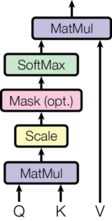

To make weights input dependent, every single token emits two vectors: a query with dimension $d_q$, and a key with dimension $d_k$. On a high level, the query vector represents what a token is looking for and the key vector corresponds to what information the token contains.


The communication strength between two tokens is the dot product between the queries and the keys. For sequence modeling, the query of the token at timestep 5 will dot product with all keys at time step 1,2,3, and 4.
If what we are looking for (the query) aligns with any of what the previous tokens contain (their keys), then the dot product between the query and that key will be very high.
Consequently, we will get more information from that specific token as opposed to any other token in the sequence.




In the preview section we multiplied the input sequence with the weights. In practice, the tokens emit a third vector (value) that is multiplied with the attention weights:


\begin{equation}
Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V
\end{equation}






---


**In summary**:


Every token emits three vectors (queries, keys, values)
1. Queries = What I am looking for
2. Keys = What do I contain
3. Values = What information do I have if you find me interesting (high dot product)




**Important notes**:
1. Attention is a mechanism that allows tokens to communicate with each other in a data dependent way
2. Attention does not model positional information, i.e. it does not know the order of the tokens in the sequence. This is why we need to add positional encodings to the input embeddings.
3. Elements across batches do not communicate with each other.
4. In auto-regressive models, the attention mechanism is used to allow tokens to communicate with each other in a causal way, i.e. tokens can only communicate with tokens that came before them
but attention is not limited to auto-regressive models, it can be used in any model where tokens need to communicate with each other. As we will see shortly, we allow all tokens $i$ to communicate with all other tokens $j$ in a bi-directional way in the encoder.
5. Self attention vs Cross attention:
   * Self attention: tokens communicate with each other within the same sequence
   * Cross attention: tokens communicate with each other across different sequences (this is part of the decoder block in encoder-decoder models, where the tokens in the decoder communicate with the output of the encoder. In this setting, the only actual difference is that the keys and the values are coming from this external source).


   Self attention is used when the information that is aggregated depends on the input sequence alone.


   Cross attention is used whenever there is external information that we want to pull into our
   sequence.


6. The last element is the division by the square root of the head size ($d_k$). The reason for this is to preserve the variance of the keys and the queries. This is important because the weights are passed through the softmax and its really important that the weights are fairly distributed. If we have weights with very high magnitude then the softmax converges to usually one-hot vectors by sharpening the input vector towards the max of that vector.
7. Modern transformers employ multi-headed attention, this is just applying multiple attentions in parallel and concatenating the results. We will implement the attention formula in the section below with this in mind so that we can plug it into our model.

In [ ]:
def make_triangular_attention_mask(size: int) -> torch.Tensor:
    """Mask out subsequent positions."""
    attn_shape = (1, size, size)
    # Create a triangular attention mask to mask out subsequent positions
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return subsequent_mask == 0

In [ ]:
def example_mask() -> alt.Chart:
    """Example of a triangular attention mask."""
    dataframe = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": make_triangular_attention_mask(20)[0][x, y].flatten(),
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(dataframe)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )


show_example(example_mask)

### ⭐ Your time to shine ⭐: Implement the attention function

In [ ]:
def attention(
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    mask: torch.Tensor | None = None,
    mask_value: float = -1e9,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Compute scaled-dot product attention.

    The attention formula is defiend as: attention(Q, K, V) = softmax(QK^T / sqrt(d_k))V.

    Args:
        query (torch.Tensor): Query tensor of shape (batch_size, num_heads, seq_len, d_k)
        key (torch.Tensor): Key tensor of shape (batch_size, num_heads, seq_len, d_k)
        value (torch.Tensor): Value tensor of shape (batch_size, num_heads, seq_len, d_k)
        mask (torch.Tensor, optional): Mask tensor of shape (batch_size, 1 , seq_len, seq_len)
        mask_value (float, optional): Value to use for masking. Defaults to -1e9.
    """
    # Step 1: Get the dimension of the query used to scale the dot product of the query and key.

    # Step 2: Compute the dot product between the query and key:
    # We need to transpose the key tensor to match the dimensions of the query tensor
    # The queries have shape of (batch_size, num_heads, seq_len, d_k)
    # The keys have shape of (batch_size, num_heads, seq_len, d_k)
    # The dot product of between the queries and keys will have the shape of
    # (batch_size, num_heads, seq_len, seq_len)
    # Hint: Use key.transpose(x, y), what are the values of x and y?
    # Finally, scale the dot-product by the square root of the d_k

    # Step 3: Apply the mask to the scores using the mask_value for tokens that we dont consider.
    # Hint: Use the masked_fill function

    # Step 4: Compute the attention weights by applying the softmax function to the scores

    # Step 5: Finally, multiply the attention weights by the value tensor
    raise NotImplementedError

Test your implementation.

**Do not modify these cells as they are used to verify that your implementation is correct and avoid future bugs.**

In [ ]:
!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/queries.pt?download=true -O queries.pt
!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/keys.pt?download=true -O keys.pt

!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/expected_cross_attention_output.pt?download=true -O expected_cross_attention_output.pt
!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/expected_cross_attention_weights.pt?download=true -O expected_cross_attention_weights.pt
!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/expected_masked_cross_attention_output.pt?download=true -O expected_masked_cross_attention_output.pt
!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/expected_masked_cross_attention_weights.pt?download=true -O expected_masked_cross_attention_weights.pt
!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/expected_masked_self_attention_output.pt?download=true -O expected_masked_self_attention_output.pt
!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/expected_masked_self_attention_weights.pt?download=true -O expected_masked_self_attention_weights.pt
!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/expected_self_attention_output.pt?download=true -O expected_self_attention_output.pt
!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/expected_self_attention_weights.pt?download=true -O expected_self_attention_weights.pt

In [ ]:
def test_attention_function() -> None:
    """Test the attention function."""
    # Verify the self-attention output and weights
    # queries = torch.rand(4, 8, 10, 64)
    queries = torch.load("queries.pt")

    self_attention_output, self_attention_weights = attention(queries, queries, queries)

    expected_self_attention_output = torch.load("expected_self_attention_output.pt")
    expected_self_attention_weights = torch.load("expected_self_attention_weights.pt")

    is_close = torch.allclose(self_attention_output, expected_self_attention_output)
    assert is_close, "Self-attention output is incorrect"

    is_close = torch.allclose(self_attention_weights, expected_self_attention_weights)
    assert is_close, "Self-attention weights are incorrect"

    # Verify the cross-attention output and weights
    # keys = torch.rand(4, 8, 20, 64)
    keys = torch.load("keys.pt")

    cross_attention_output, cross_attention_weights = attention(queries, keys, keys)

    expected_cross_attention_output = torch.load("expected_cross_attention_output.pt")
    expected_cross_attention_weights = torch.load("expected_cross_attention_weights.pt")

    is_close = torch.allclose(cross_attention_output, expected_cross_attention_output)
    assert is_close, "Cross-attention output is incorrect"

    is_close = torch.allclose(cross_attention_weights, expected_cross_attention_weights)
    assert is_close, "Cross-attention weights are incorrect"

    # Verify the masked self-attention output and weights
    mask = make_triangular_attention_mask(10).unsqueeze(0).repeat(4, 1, 1, 1)
    masked_self_attention_output, masked_self_attention_weights = attention(
        queries, queries, queries, mask
    )

    expected_masked_self_attention_output = torch.load("expected_masked_self_attention_output.pt")
    expected_masked_self_attention_weights = torch.load(
        "expected_masked_self_attention_weights.pt"
    )

    is_close = torch.allclose(masked_self_attention_output, expected_masked_self_attention_output)

    assert is_close, "Masked self-attention output is incorrect"

    is_close = torch.allclose(
        masked_self_attention_weights, expected_masked_self_attention_weights
    )
    assert is_close, "Masked self-attention weights are incorrect"

    # Verify the masked cross-attention output and weights
    mask = torch.ones(4, 1, 1, 20)
    masked_cross_attention_output, masked_cross_attention_weights = attention(
        queries, keys, keys, mask
    )

    expected_masked_cross_attention_output = torch.load(
        "expected_masked_cross_attention_output.pt"
    )
    expected_masked_cross_attention_weights = torch.load(
        "expected_masked_cross_attention_weights.pt"
    )

    is_close = torch.allclose(
        masked_cross_attention_output, expected_masked_cross_attention_output
    )
    assert is_close, "Masked cross-attention output is incorrect"

    is_close = torch.allclose(
        masked_cross_attention_weights, expected_masked_cross_attention_weights
    )
    assert is_close, "Masked cross-attention weights are incorrect"

    print("All tests passed!")

test_attention_function()

#### Multihead attention

Now that we have the attention formula we need to implement the forward pass of the multihead attention module:

<div align="center">

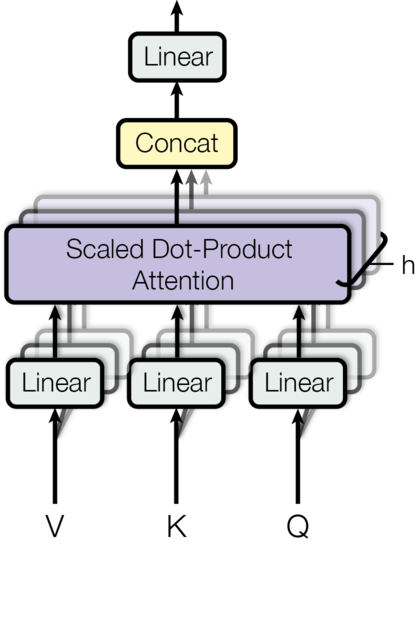

<div>

We want to implement the following formula:

$$
\mathrm{MultiHead}(Q, K, V) =
    \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

Where the projections are parameter matrices $W^Q_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in
\mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in
\mathbb{R}^{hd_v \times d_{\text{model}}}$.

In [ ]:
class MultiHeadedAttention(nn.Module):
    """Multi-headed attention."""

    def __init__(self, d_model: int, num_heads: int) -> None:
        super().__init__()
        assert d_model % num_heads == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        # Use a single module instead of having separate linear modules for each attention head
        self.query_projection = nn.Linear(d_model, d_model)
        self.key_projection = nn.Linear(d_model, d_model)
        self.value_projection = nn.Linear(d_model, d_model)

        self.output_projection = nn.Linear(d_model, d_model)

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """Forward pass of the multi-headed attention module."""
        # Same mask applied to all attention heads.
        if mask is not None:
            mask = mask.unsqueeze(1)
        batch_size = query.size(0)

        # Step 1: Do all linear projections for queries, keys and values

        # Step 2: Reshape the projected queries, keys and values to have multiple heads
        # The queries have shape of (batch_size, seq_len, d_model), we want to reshape it to
        # (batch_size, num_heads, seq_len, d_k) so that we can apply the multi-head attention
        # Hint: Use .view() and .transpose() to reshape the queries, keys, and values
        # Apply the same reshaping to the keys and values

        # Step 3: Apply attention on all the projected vectors in batch

        # Step 4: Concatenate the attention outputs from all heads. We have computed the attention
        # for each head separately, now we need to concatenate the outputs of each head to get the
        # final multi-headed attention output. The shape of the multi-head attention is:
        # (batch_size, num_heads, seq_len, d_model // num_heads)
        # We need to reshape it back to (batch_size, seq_len, num_heads * d_k)
        # Hint: Use .transpose() and then .view() to reshape the attention_output. You will also
        # need to do .contiguous() after the transpose

        # Step 5: Apply a final linear projection to get the final multi-headed attention output
        raise NotImplementedError

Test your implementation.

**Do not modify these cells as it used to verify that your implementation is correct and avoid future bugs.**

In [ ]:
!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/mha_module.pt?download=true -O mha_module.pt
!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/mha_queries.pt?download=true -O mha_queries.pt
!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/mha_keys.pt?download=true -O mha_keys.pt

!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/expected_cross_mha_output.pt?download=true -O expected_cross_mha_output.pt
!wget https://huggingface.co/gpantaz/athnlp_lab4_tests/resolve/main/expected_self_mha_output.pt?download=true -O expected_self_mha_output.pt

In [ ]:
def test_multi_headed_attention() -> None:
    """Test the multi-headed attention class."""
    mha = MultiHeadedAttention(d_model=64, num_heads=8)
    mha.load_state_dict(torch.load("mha_module.pt"), strict=False)

    # queries = torch.randn(4, 10, 64)
    queries = torch.load("mha_queries.pt")
    mask = make_triangular_attention_mask(10).repeat(4, 1, 1)
    mha_output = mha(queries, queries, queries, mask)

    expected_mha_output = torch.load("expected_self_mha_output.pt")

    is_close = torch.allclose(mha_output, expected_mha_output, atol=5e-7)
    assert is_close, "Multi-headed attention output is incorrect"

    keys = torch.load("mha_keys.pt")
    mask = torch.ones(4, 1, 1, 20)
    mha_output = mha(queries, keys, keys)

    expected_mha_output = torch.load("expected_cross_mha_output.pt")

    is_close = torch.allclose(mha_output, expected_mha_output, atol=5e-7)
    assert is_close, "Multi-headed attention output is incorrect"

    print("All tests passed!")

test_multi_headed_attention()

## LayerNorm

In [ ]:
class LayerNorm(nn.Module):
    """Layer normalization module."""

    def __init__(self, d_model: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(d_model))
        self.b_2 = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Forward pass of the layer normalization module."""
        mean = inputs.mean(-1, keepdim=True)
        std = inputs.std(-1, keepdim=True)
        return self.a_2 * (inputs - mean) / (std + self.eps) + self.b_2

<a name="section:embeddings"></a>
## Embeddings


Similar to other sequence-to-sequence models, we need learnable embeddings that convert the input, and output tokens to vectors.

In [ ]:
class Embeddings(nn.Module):
    """Simple Embedding module."""

    def __init__(self, d_model: torch.Tensor, vocab: int) -> None:
        super().__init__()
        self.embeddings = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the embeddings module."""
        return self.embeddings(x) * math.sqrt(self.d_model)

<a name="section:pos_enc"></a>
## Positional Encoding


Most Transformer models incorporate some positional information. In the original Transformer model, the embeddings of a token $m$, $x_m$ are summed with a positional encoding function $PE(m)$, so that:

$$\mathbf{x_m}' = \mathbf{x_m} + PE(m)$$

---
**Question** Why do you think we need positional information in Transformers?

<details>
<summary><strong>Answer</strong></summary>


>We have already stated that the attention operation is permutation invariant. The tokens in two sequences will have the same attention weights if the sequences have the same tokens just in different order. But we are doing sequence modeling!


>The sentence "Transformers are better than RNNs" means something completely different than "RNNs are better than Transformers". For this reason, the tokens in the sequence should accommodate some sort of positional information when computing the attention.
</details>

The original Transformer model applies sine and cosine functions of different frequencies to model positional information:

$$PE_{(pos,2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})$$

<!-- For example, for a sequence of 8 tokens and an embedding dimension of 2, we model each position as:

<div align="center">

| n | x | y |
| :--: | :--: | :--: |
| 0 | 1.0000 | 2.0000 |
| 1 | 1.8415 | 1.5403 |
| 2 | 1.9093 | 0.5839 |
| 3 | 1.1411 | 0.0100 |
| 4 | 0.2432 | 0.3464 |
| 5 | 0.0411 | 1.2837 |
| 6 | 0.7206 | 1.9602 |
| 7 | 1.6570 | 1.7539 |

</div> -->


In the below example we show the impact of the sinusoidal positional embeddings applied to a sequence of embeddings. For simplicity, assume that the embeddings have two dimensions and each token in the sequence is a vector $x = [1, 1]$.

In [ ]:
def example_positional_2d() -> alt.Chart:
    """Example of positional information on a 2D vector."""
    d_model = 2
    max_len = 8
    base = 10000.0
    input_vector = torch.ones(max_len, d_model)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(base) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    embedding = input_vector + pe

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "x": [0, embedding[n, 0].item()],
                    "y": [0, embedding[n, 1].item()],
                    "position": n,
                }
            )
            for n in list(range(max_len))
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="x", y="y", color="position:N")
        .interactive()
    )

show_example(example_positional_2d)

Notice that both the magnitude and the angle of the same embedding vector ($x = [1, 1]$) are impacted significantly. As we will see later on, this is not a good practice and sinusoidal embeddings are one of the few things that has changed over the original Transformer. The reason for this is that the model perceives a token by its embedding. From this graph, the same token can have very different embeddings, after positional encoding making it challenging for the model to understand that all of these vectors refer to the same token.

In [ ]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""

    def __init__(
        self, d_model: int, dropout: float, max_len: int = 5000, base: float = 10000.0
    ) -> None:
        super().__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # This is used to normalise the embedding representations and avoid overfitting
        # Read more about it here: https://jmlr.org/papers/v15/srivastava14a.html
        self.dropout = nn.Dropout(p=dropout)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the positional encoding module."""
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [ ]:
def example_positional() -> alt.Chart:
    """Example of positional encoding."""
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)

<a name="section:model"></a>
## Full Model


In [ ]:
def make_model(
    src_vocab: int,
    tgt_vocab: int,
    num_layers: int = 6,
    d_model: int = 512,
    num_heads: int = 8,
    intermediate_size: int = 2048,
    dropout: float = 0.1,
    attention_dropout: float = 0.1,
) -> EncoderDecoder:
    """Construct a model from hyperparameters."""
    model = EncoderDecoder(
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        num_layers=num_layers,
        d_model=d_model,
        intermediate_size=intermediate_size,
        num_heads=num_heads,
        dropout=dropout,
        attention_dropout=attention_dropout,
    )

    # To improve model convergence and training stability,
    # we initialize parameters in a specific way called Xavier or Glorot Initialization
    # (see https://paperswithcode.com/method/xavier-initialization)
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

<a name="section:example_inference"></a>
## Example Inference


In [ ]:
def inference_test() -> None:
    """Test the inference of the model."""
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    encoder_outputs = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        # generate an output representation given the input
        out = test_model.decode(
            encoder_outputs,
            src_mask,
            ys,
            make_triangular_attention_mask(ys.size(1)).type_as(src.data),
        )
        # use the language modelling head to generate a probability distribution over the tokens
        prob = test_model.lm_head(out[:, -1])
        # greedy sampling: select the element with the highest probability
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1)

    print("Example Untrained Model Prediction:", ys)


for _ in range(10):
    inference_test()

<a name="section:model_training"></a>
# Part 2: Model Training

Below we provide the minimum components required to train the model that we defined on Part 1. You do not need to implement anything, though just make sure that you have run the cells to ensure that we can train the model on the follow-up part.


Start by creating a class that represents a batch used during training


In [ ]:
class Batch:
    """A batch class used for training."""

    def __init__(self, src: torch.Tensor, tgt: torch.Tensor | None = None, pad: int = 2) -> None:
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt: torch.Tensor, pad: int) -> torch.Tensor:
        """Create a mask to hide padding and future words."""
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & make_triangular_attention_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask

Minimal implementation of training loop

In [ ]:
class TrainState:
    """Track number of steps, and examples processed."""

    # Steps in the current epoch
    step: int = 0
    # Number of gradient accumulation steps
    accum_step: int = 0
    # number of examples used
    samples: int = 0


In [ ]:
def run_epoch(
    data_iter: Iterable[Batch],
    model: EncoderDecoder,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    mode: Literal["train", "eval"] = "train",
    accum_iter: int = 1,
    train_state: TrainState = TrainState(),
    num_batches: int = 20,
    epoch: int = 0,
) -> tuple[torch.Tensor, TrainState]:
    """Train a single epoch."""
    total_loss = torch.Tensor([0.0])
    n_accum = 0

    pbar = tqdm(data_iter, total=num_batches, desc=f"Epoch {epoch}: {mode}")
    for batch_idx, batch in enumerate(pbar):
        out = model.forward(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask, batch.tgt_y)
        loss = out["loss"]
        if mode == "train":
            loss.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            if batch_idx % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        pbar.set_postfix({"Average Loss": (total_loss / batch_idx).item()})

    return total_loss / train_state.samples, train_state

Learning Rate scheduling

In [ ]:
def rate(step: int, model_size: int, factor: float, warmup: int) -> float:
    """Implement the learning rate schedule.

    The learning rate is increased linearly for the first warmup steps, and then decreased
    proportionally to the inverse square root of the step number.
    """
    # We have to default the step to 1 for LambdaLR function to avoid zero raising to negative power.
    if step == 0:
        step = 1
    return factor * (model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5)))

In [ ]:
def example_learning_schedule() -> alt.Chart:
    """Example of learning rate schedule."""
    opts = [
        [512, 1, 4000],  # example 1
        [512, 1, 8000],  # example 2
        [256, 1, 4000],  # example 3
    ]

    dummy_model = torch.nn.Linear(1, 1)
    learning_rates = []

    # we have 3 examples in opts list.
    for idx, example in enumerate(opts):
        # run 20000 epoch for each example
        optimizer = torch.optim.Adam(dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9)
        lr_scheduler = LambdaLR(optimizer=optimizer, lr_lambda=lambda step: rate(step, *example))
        tmp = []
        # take 20K dummy training steps, save the learning rate at each step
        for step in range(20000):
            tmp.append(optimizer.param_groups[0]["lr"])
            optimizer.step()
            lr_scheduler.step()
        learning_rates.append(tmp)

    learning_rates = torch.tensor(learning_rates)

    # Enable altair to handle more than 5000 rows
    alt.data_transformers.disable_max_rows()

    opts_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Learning Rate": learning_rates[warmup_idx, :],
                    "model_size:warmup": ["512:4000", "512:8000", "256:4000"][warmup_idx],
                    "step": range(20000),
                }
            )
            for warmup_idx in [0, 1, 2]
        ]
    )

    return (
        alt.Chart(opts_data)
        .mark_line()
        .properties(width=600)
        .encode(x="step", y="Learning Rate", color="model_size:warmup:N")
        .interactive()
    )


example_learning_schedule()

<a name="section:first_example"></a>
# Part 3: A First Example: Learning to Copy

Now that we have our training loop ready, we can train our model. We begin by applying our model on a simple copying task. Given a random sequence of tokens, the goal of the model is to output the same sequence in the exact same order. Note that similar to Part 2, you will not need to implement anything, though make sure to run the cells as some functions are required on Part 4.


The copying task is ideal to inspect model behavior on a small scale and for debugging purposes. Additionally, being able to copy the entire input (or retrieve certain parts from it) directly correlates with the capabilities of larger models (you can see more details [here](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html))


In [ ]:
def data_gen(
    vocabulary_size: int, batch_size: int, nbatches: int, seq_len: int
) -> Iterable[Batch]:
    """Generate random data for a src-tgt copy task."""
    for _ in range(nbatches):
        data = torch.randint(1, vocabulary_size, size=(batch_size, seq_len))
        # Set the beginning of the sequence to 0 as the start symbol
        data[:, 0] = 0
        src = data.clone()
        tgt = data.clone()
        yield Batch(src, tgt, vocabulary_size)

Minimal implementation of greedy decode.

Within a loop of fixed number of iterations do a forward pass and obtain the logits for the last timestep. The predicted token corresponds to the index of the maximum value of the logits. Append the predicted token at the input sequence and continue to generate future tokens in an autoregressive manner. If at any point the model outputs the end symbol we terminate the generation.

In [ ]:
def greedy_decode(
    model: EncoderDecoder,
    src: torch.Tensor,
    src_mask: torch.Tensor,
    max_len: int,
    start_symbol: int = 0,
    end_symbol: int = -1,
) -> torch.Tensor:
    """Simple greedy decoding."""
    encoder_outputs = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for _ in range(max_len - 1):
        out = model.decode(
            encoder_outputs,
            src_mask,
            ys,
            make_triangular_attention_mask(ys.size(1)).type_as(src.data),
        )
        prob = model.lm_head(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        if next_word == end_symbol:
            break
        ys = torch.cat([ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [ ]:
def example_copying(
    vocabulary_size: int = 11,
    train_seq_len: int = 10,
    test_seq_len: int = 10,
    num_layers: int = 2,
    d_model: int = 512,
    intermediate_size: int = 2048,
    num_heads: int = 8,
    dropout: float = 0.1,
    attention_dropout: float = 0.1,
    num_training_batches: int = 20,
    num_eval_batches: int = 5,
    batch_size: int = 20,
    num_epochs: int = 10,
) -> None:
    """Example of a simple model training."""
    model = make_model(
        src_vocab=vocabulary_size,
        tgt_vocab=vocabulary_size,
        num_layers=num_layers,
        d_model=d_model,
        intermediate_size=intermediate_size,
        num_heads=num_heads,
        dropout=dropout,
        attention_dropout=attention_dropout,
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9)
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )

    for epoch in range(num_epochs):
        model.train()
        run_epoch(
            data_gen(vocabulary_size, batch_size, num_training_batches, train_seq_len),
            model,
            optimizer,
            lr_scheduler,
            mode="train",
            num_batches=num_training_batches,
            epoch=epoch,
        )
        model.eval()
        run_epoch(
            data_gen(vocabulary_size, batch_size, num_eval_batches, train_seq_len),
            model,
            None,
            None,
            mode="eval",
            num_batches=num_eval_batches,
            epoch=epoch,
        )

    # Lets test a couple of sequences:
    model.eval()
    print("Predictions")
    num_sequences = 10
    for _ in range(num_sequences):
        src = torch.concatenate(
            [torch.tensor([[0]]), torch.randint(1, vocabulary_size, size=(1, test_seq_len))], dim=-1
        )
        src_mask = torch.ones(1, 1, src.shape[1])
        tgt = greedy_decode(model, src, src_mask, max_len=src.shape[1], start_symbol=0)
        print(f"input: {src} output: {tgt}")

In [ ]:
example_copying(
    vocabulary_size=11,
    train_seq_len=10,
    test_seq_len=10,
    num_layers=2,
    d_model=512,
    intermediate_size=2048,
    num_heads=8,
    dropout=0.1,
    attention_dropout=0.1,
    num_training_batches=20,
    num_eval_batches=5,
    batch_size=20,
    num_epochs=10,
)

**Question**:


Do you think the model learns to copy the input sequence, or the copy function with an input sequence of exactly 10 tokens?


What happens if the sequence during testing is longer than the ones used in training?


Is the model also able to extrapolate to longer sequences?


---


**Question**:
Can you try to guess why Transformers are better at tasks similar to copying compared to RNNs?


<details>
<summary><strong>Answer</strong></summary>


>RNNs are limited by a finite hidden state. When RNNs encode a sequence they update their hidden state one time step at a time. In other words, the value of the hidden state depends solely on the current input and the value of the previous state.


>While Transformers also have a hidden size, the representation of a token at a timestep $t$ is updated after having direct access to every other previous token $\tau$.


> Now imagine during a copying task that an RNN fails to memorize a token in the sequence. Clearly there is no hope for the model to fully recover the correct output as the token is not included in the memory. Transformers on the other hand will always look back at all previous tokens before updating the value of the current token.
</details>

<a name="section:translation"></a>
# Part 4: Translating Spanish to Aragonese

<a name="section:es_an_dataset"></a>
## Dataset Preparation

From the [WMT 24 website](https://www2.statmt.org/wmt24/romance-task.html): In Spain, a diverse linguistic landscape exists, including, beyond the widely recognized Spanish, other languages such as Basque, Catalan, and Galician. Although Spanish is obviously at the forefront in terms of the volume of resources available for training data-driven MT systems, the capabilities and richness of the other languages should not be underestimated. This task focuses on three of them, namely, Aragonese, Aranese, and Asturian.



In the sections below we will train a model from scratch that tries to translate sentences from Spanish to Aragonese.




Download the train and validation datasets

In [ ]:
!wget https://huggingface.co/gpantaz/athnlp_lab4_data/resolve/main/train_an-es.json?download=true -O train_an-es.json
!wget https://huggingface.co/gpantaz/athnlp_lab4_data/resolve/main/val_an-es.json?download=true -O val_an-es.json

Prepare the test dataset

In [ ]:
!rm -rf FLORES*
!wget https://github.com/transducens/PILAR/raw/main/FLORES+.zip
!apt-get install p7zip-full
!7za x "FLORES+.zip" -r -aoa -p"multilingual machine translation"

In [ ]:
spanish_devtest = "FLORES+/devtest/devtest.spa_Latn"
aragonese_devtest = "FLORES+/devtest/devtest.arg_Latn"
output_json_file = "flores+_devtest.json"

with open(spanish_devtest) as fp:
    spanish_sentences = [line.rstrip() for line in fp]

with open(aragonese_devtest) as fp:
    aragonese_sentences = [line.rstrip() for line in fp]

all_sentences = [
    {"es": spanish_sentence, "an": aragonese_sentence}
    for spanish_sentence, aragonese_sentence in zip(
        spanish_sentences, aragonese_sentences, strict=False
    )
]
with open(output_json_file, "w") as fp:
    json.dump(all_sentences, fp, indent=4)

del spanish_sentences
del aragonese_sentences

Lets create a Hugging Face dataset that we can use for our experiments

In [ ]:
hf_dataset = datasets.load_dataset(
    "json",
    data_files={
        "train": "train_an-es.json",
        "val": "val_an-es.json",
        "test": "flores+_devtest.json",
    },
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Lets see a couple of examples:

In [ ]:
print(hf_dataset["train"][0])
print(hf_dataset["train"][20])
print(hf_dataset["train"][-1])

Note that our dataset is quite noisy! Even if you dont understand Spanish or Aragonese you can definitely see that some pairs of sentences do not have the same meaning. That is something quite common in uncurated and/or low-resource data that we occasionally have to deal with!

Finally, a utility function to load a pretrained model from Hugging Face library along with the tokenizer, this will be used later on where we load a pretrained model and try to finetune it on the spanish-aragonese translation task.

In [ ]:
def load_pretrained_model(
    model_name: str = "google-t5/t5-base",
) -> tuple[PreTrainedModel, PreTrainedTokenizerFast]:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = model.eval()
    return model, tokenizer

<a name="section:train_from_scratch"></a>
## Train a Model From Scratch

Previously we used pure pytorch code to train our model to showcase all the necessary intermediate steps. In this section we will use the [Transformers](https://huggingface.co/docs/transformers/en/index) library that is equipped with a [Trainer](https://huggingface.co/docs/transformers/en/trainer) class that abstracts all the details for example the training loop.



In [ ]:
model_config = {
    "num_layers": 12,
    "d_model": 768,
    "num_heads": 12,
    "intermediate_size": 3072,
    "dropout": 0.0,
    "attention_dropout": 0.0,
    "sharable_embeddings": True,
}

Create our tokenizer

In [ ]:
sharable_embeddings = model_config.get("sharable_embeddings", False)

# If we have shared encoder and decoder embeddings then we need a common vocabulary
if sharable_embeddings:

    def get_training_corpus_from_all_languages(
        hf_dataset: datasets.arrow_dataset.Dataset,
    ) -> Iterable[str]:
        for example in hf_dataset["train"]:
            for language in example:
                yield example[language]

    tokenizer = tokenizers.ByteLevelBPETokenizer()
    tokenizer.normalizer = tokenizers.normalizers.Sequence([tokenizers.normalizers.NFKC()])
    tokenizer.train_from_iterator(
        get_training_corpus_from_all_languages(hf_dataset),
        vocab_size=5000,
        min_frequency=2,
        special_tokens=["<s>", "</s>", "<pad>"],
    )

    es_tokenizer = tokenizer
    an_tokenizer = tokenizer

else:

    def get_training_corpus_from_language(
        hf_dataset: datasets.arrow_dataset.Dataset, language: str = "en"
    ) -> Iterable[str]:
        for example in hf_dataset["train"]:
            yield example[language]

    es_tokenizer = tokenizers.ByteLevelBPETokenizer()
    es_tokenizer.normalizer = tokenizers.normalizers.Sequence([tokenizers.normalizers.NFKC()])
    es_tokenizer.train_from_iterator(
        get_training_corpus_from_language(hf_dataset, language="es"),
        vocab_size=5000,
        min_frequency=2,
        special_tokens=["<s>", "</s>", "<pad>"],
    )

    an_tokenizer = tokenizers.ByteLevelBPETokenizer()
    an_tokenizer.normalizer = tokenizers.normalizers.Sequence([tokenizers.normalizers.NFKC()])
    an_tokenizer.train_from_iterator(
        get_training_corpus_from_language(hf_dataset, language="an"),
        vocab_size=5000,
        min_frequency=2,
        special_tokens=["<s>", "</s>", "<pad>"],
    )


Pytorch Datasets

In [ ]:
class MachineTranslationDataset(Dataset):
    """A simple torch dataset for machine translation."""

    def __init__(
        self,
        dataset: datasets.arrow_dataset.Dataset,
        src_tokenizer: tokenizers.Tokenizer,
        tgt_tokenizer: tokenizers.Tokenizer,
        src_language: str = "es",
        tgt_language: str = "an",
        bos_symbol: str = "<s>",
        eos_symbol: str = "</s>",
    ) -> None:
        self.dataset = dataset
        self.dataset_size = len(dataset)

        self.tgt_tokenizer = tgt_tokenizer
        self.src_tokenizer = src_tokenizer

        self.src_language = src_language
        self.tgt_language = tgt_language

        self.bos_symbol = bos_symbol
        self.eos_symbol = eos_symbol

    def __len__(self) -> int:
        """Return the size of the dataset."""
        return self.dataset_size

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Get an item from the dataset."""
        processed_src_text = self.process_text(self.dataset[idx][self.src_language])
        processed_tgt_text = self.process_text(self.dataset[idx][self.tgt_language])

        src = torch.tensor(self.src_tokenizer.encode(processed_src_text).ids)
        tgt = torch.tensor(self.tgt_tokenizer.encode(processed_tgt_text).ids)

        return src, tgt

    def process_text(self, text: str) -> str:
        """Process the text."""
        text = text.strip()
        # Add full stop at the end of the sentence
        if not text.endswith("."):
            text = f"{text}."

        # Ensure that the first letter is capitalized
        text = text[0].upper() + text[1:]

        # Add the bos / eos symbol
        text = f"{self.bos_symbol}{text}{self.eos_symbol}"
        return text


class Collate:
    """Collate function for the dataset."""

    def __init__(self, padding_token_id: int = 2, max_len: int = 128) -> None:
        self.padding_token_id = padding_token_id
        self.max_len = max_len

    def __call__(
        self, src_tgt_list_pairs: list[tuple[torch.Tensor, torch.Tensor]]
    ) -> dict[str, torch.Tensor]:
        """Collate function for the dataset."""
        # Step 1: Pad the source and target sequences with the padding token
        src = torch.nn.utils.rnn.pad_sequence(
            [pair[0] for pair in src_tgt_list_pairs],
            batch_first=True,
            padding_value=self.padding_token_id,
        )
        tgt = torch.nn.utils.rnn.pad_sequence(
            [pair[1] for pair in src_tgt_list_pairs],
            batch_first=True,
            padding_value=self.padding_token_id,
        )

        # Step 2: Truncate the sequences to max_len
        src = src[:, : self.max_len]
        tgt = tgt[:, : self.max_len]

        batch = Batch(src, tgt, self.padding_token_id)
        # Step 3: Replace padding tokens with -100 in the labels so that they are not considered
        # in the loss
        labels = batch.tgt_y.clone()
        labels[labels == self.padding_token_id] = -100
        return {
            "src": batch.src,
            "tgt": batch.tgt,
            "src_mask": batch.src_mask,
            "tgt_mask": batch.tgt_mask,
            "labels": batch.tgt_y,
        }

train_dataset = MachineTranslationDataset(
    dataset=hf_dataset["train"],
    src_tokenizer=es_tokenizer,
    tgt_tokenizer=an_tokenizer,
    src_language="es",
    tgt_language="an",
)

val_dataset = MachineTranslationDataset(
    dataset=hf_dataset["val"],
    src_tokenizer=es_tokenizer,
    tgt_tokenizer=an_tokenizer,
    src_language="es",
    tgt_language="an",
)

test_dataset = MachineTranslationDataset(
    dataset=hf_dataset["test"],
    src_tokenizer=es_tokenizer,
    tgt_tokenizer=an_tokenizer,
    src_language="es",
    tgt_language="an",
)

**Warning**: Due to limited resources on google colab it is very likely that you will not be able to train a model. The code below is for educational purposes, you can skip it and directly go to the evaluation section. We will provide you with a trained model using exactly the same code and training hyperparameters for you so that you can inspect predictions.

In [ ]:
# Dont use wandb to log the experiment
os.environ["WANDB_DISABLED"] = "true"

training_args = transformers.TrainingArguments(
    output_dir="storage/models/from-scratch-model-es-an-translation",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=8,
    logging_steps=1,
    save_strategy="steps",
    save_steps=0.05,
    num_train_epochs=10,
    learning_rate=5e-4,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    bf16=True,
    fp16=False,
    gradient_checkpointing=False,
    save_total_limit=2,
    load_best_model_at_end=True,
    log_level="debug",
    save_safetensors=False,
    eval_strategy="steps",
    eval_steps=0.05,
    seed=123456789,
    data_seed=123456789,
    dataloader_num_workers=4,
    logging_nan_inf_filter=False,
)

model = EncoderDecoder(
    src_vocab=es_tokenizer.get_vocab_size(),
    tgt_vocab=an_tokenizer.get_vocab_size(),
    **model_config,
)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {trainable_params}")

collate_fn = Collate(padding_token_id=2, max_len=128)

trainer = transformers.Trainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
)

trainer.train()

del trainer

<a name="section:eval_from_scratch"></a>
## Evaluate a Model Trained From Scratch

In [ ]:
!wget https://huggingface.co/gpantaz/athnlp_lab4_enc_dec_base/resolve/main/pytorch_model.bin?download=true -O pytorch_model.bin

In [ ]:
model = EncoderDecoder(
    src_vocab=es_tokenizer.get_vocab_size(),
    tgt_vocab=an_tokenizer.get_vocab_size(),
    **model_config,
)

state_dict = torch.load("pytorch_model.bin", map_location=torch.device("cpu"))
model.load_state_dict(state_dict)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model = model.eval()

<ipython-input-52-7fb5b7dce5a8>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("pytorch_model.bin", map_location=torch.device("cpu"))


Evaluation metrics:

In [ ]:
predictions = []
references = []
# Set this to len(test_dataset) to evaluate on the whole test set
# It takes too long though!
max_examples = 100
for example in tqdm(test_dataset, total=max_examples, desc="Running inference"):
    src, tgt = example

    src = src.unsqueeze(0).to(model.lm_head.weight.device)
    tgt = tgt.unsqueeze(0).to(model.lm_head.weight.device)
    src_mask = torch.ones(1, 1, src.shape[1]).to(model.lm_head.weight.device)

    with torch.no_grad():
        pred = greedy_decode(model, src, src_mask, max_len=128, start_symbol=0, end_symbol=1)

    target_str = an_tokenizer.decode(tgt[0].tolist())
    references.append([target_str])

    pred_str = es_tokenizer.decode(pred[0].tolist())
    predictions.append(pred_str)

    if len(predictions) == max_examples:
        break


bleu = evaluate.load("sacrebleu")
bleu_results = bleu.compute(predictions=predictions, references=references)

chrf_plusplus = evaluate.load("chrf", word_order=2)
chrf_plusplus_results = chrf_plusplus.compute(predictions=predictions, references=references)

print(f"BLEU: {bleu_results}")
print(f"CHRF++: {chrf_plusplus_results}")

del bleu
del chrf_plusplus
del predictions
del references

<a name="section:train_mt5"></a>
## Finetune a Pretrained Transformer

You probably have noticed that the predictions of our model are very unsatisfactory. Why?


Notice that our training data is pretty noisy. Even if you do not speak Spanish or Aragonese you can surely understand that some pairs are not exactly "aligned", i.e the meaning of the two sentences is not the same.


Additionally, most state-of-the-art models across many NLP tasks are trained with a vast amount of resources, are significantly larger than our toy model, and are trained for many hours on a GPU cluster with hundreds of nodes (not on a colab for 20 mins!).


These two issues are the primary bottlenecks in many applications:
* How to obtain clean, high quality data for my machine translation task?
* How can I use a capable model with limited compute?




Here, we will only provide a partial solution to the second problem. We will use a pretrained model, i.e a model that was trained with lots of data for many hours on a different task as a starting point. We say that we finetune a pretrained model by training it on our smaller data task and for fewer training updates. In other words, instead of randomly initializing the weights of our model, we will use the weights of the pretrained model and continue to train on our translation task.


More specifically, we will use the  [mT5](https://aclanthology.org/2021.naacl-main.41/) model which is essentially an encoder-decoder transformer trained on a multilingual dataset of 101 languages. mT5 is based on the [Text-to-Text Transfer Transformer (T5)](https://www.jmlr.org/papers/v21/20-074.html) that uses a unified text-to-text format and scale achieve state-of-the-art results on a wide variety of English-only NLP tasks.

In [ ]:
def preprocess_text(text: str) -> str:
    """Minimal text preprocessing."""
    text = text.strip()
    text = text[0].upper() + text[1:]
    if not text.endswith("."):
        text += "."
    return text


def preprocess_function(
    examples: datasets.formatting.formatting.LazyBatch,
    tokenizer: transformers.models.t5.tokenization_t5_fast.T5TokenizerFast,
) -> dict[str, torch.Tensor]:
    """Preprocess the examples."""
    inputs = [example.strip() for example in examples["es"]]
    targets = [example.strip() for example in examples["an"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    # Return the inputs to the model, ie the input_ids, attention_mask and labels
    return model_inputs

In [ ]:
pretrained_checkpoint_name = "google/mt5-base"

model, tokenizer = load_pretrained_model(pretrained_checkpoint_name)

tokenized_dataset = hf_dataset.map(
    preprocess_function, batched=True, fn_kwargs={"tokenizer": tokenizer}
)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=pretrained_checkpoint_name)

**Warning**: Due to limited resources on google colab it is very likely that you will not be able to train a model. The code below is for educational purposes, you can skip it and directly go to the evaluation section. We will provide you with a trained model using exactly the same code and training hyperparameters for you so that you can inspect predictions.

In [ ]:
# Dont use wandb to log the experiment
os.environ["WANDB_DISABLED"] = "true"

training_args = transformers.TrainingArguments(
    output_dir="storage/models/mt5-base-model-es-an-translation",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=8,
    logging_steps=1,
    save_strategy="steps",
    save_steps=0.1,
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    bf16=True,
    fp16=False,
    gradient_checkpointing=False,
    save_total_limit=2,
    load_best_model_at_end=True,
    log_level="debug",
    save_safetensors=True,
    eval_strategy="steps",
    eval_steps=0.1,
    seed=12345,
    data_seed=12345,
    dataloader_num_workers=4,
    logging_nan_inf_filter=False,
)

model.config.keys_to_ignore_at_inference.append("logits")

trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

<a name="section:eval_mt5"></a>
## Evaluate a Finetuned Model

Load the already finetuned model from [Hugging Face](https://huggingface.co/gpantaz/athnlp_lab4_mt5_base) and measure BLEU and CHRF++ scores.

Note that we will use the [.generate()](https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/text_generation#transformers.GenerationMixin.generate) to do autoregressive generation. This is a built-in functionality of models from Hugging Face for greedy decoding, and other generation methods.


In [ ]:
# Load the finetuned model
model, tokenizer = load_pretrained_model("gpantaz/athnlp_lab4_mt5_base")

tokenized_dataset = hf_dataset.map(
    preprocess_function, batched=True, fn_kwargs={"tokenizer": tokenizer}
)

predictions = []
references = []
# Set this to len(test_dataset) to evaluate on the whole test set
# It takes too long though!
max_examples = 100
for example in tqdm(tokenized_dataset["test"], total=max_examples, desc="Running inference"):
    input_ids = torch.tensor(example["input_ids"]).unsqueeze(0).to(model.device)
    attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=128,
            output_attentions=True,
            return_dict_in_generate=True,
        )
        outputs_str = tokenizer.batch_decode(outputs["sequences"], skip_special_tokens=True)
        predictions.extend(outputs_str)

        references.extend([example["es"]])

    if len(predictions) == max_examples:
        break

bleu = evaluate.load("sacrebleu")
bleu_results = bleu.compute(predictions=predictions, references=references)

chrf_plusplus = evaluate.load("chrf", word_order=2)
chrf_plusplus_results = chrf_plusplus.compute(predictions=predictions, references=references)

print(f"BLEU: {bleu_results}")
print(f"CHRF++: {chrf_plusplus_results}")

del bleu
del chrf_plusplus
del predictions
del references

<a name="section:attention_visualization"></a>
## Attention Visualization

In the final section of Part 4, we can view the attention weights from each layer of the encoder or the decoder.

Run the below cell and inspect the attention weights for the encoder. Use the dropdown menu on the left to change the view to the self attention, or the cross attention of the decoder. Which tokens attend to each other the most?

Some of the visualizations will fail (runtime disconnection) when the input text is long. We have truncated the input to a maximum of 40 characters but you can try and remove this and/or introduce the `include_layers` parameter to output only a selection of layers.

In [ ]:
from bertviz import model_view

model, tokenizer = load_pretrained_model("gpantaz/athnlp_lab4_mt5_base")

tokenized_dataset = hf_dataset.map(
    preprocess_function, batched=True, fn_kwargs={"tokenizer": tokenizer}
)

pair = hf_dataset["test"][39]

print(pair["es"])
print(pair["an"])

# Truncate the input to a maximum of 40 tokens to ensure that the plot doesnt fail
encoder_input_ids = tokenizer(pair["es"], return_tensors="pt", add_special_tokens=True).input_ids[:, :40]
decoder_input_ids = tokenizer(pair["an"], return_tensors="pt", add_special_tokens=True).input_ids[:, :40]

encoder_input_ids = encoder_input_ids.to(device=model.device)
decoder_input_ids = decoder_input_ids.to(device=model.device)

with torch.no_grad():
    outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids, output_attentions=True)

encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens=decoder_text,
    #include_layers=[0, 4, 8, 11],
)



<a name="section:idiomatic"></a>
# Part 5: Translating Idiomatic Sentences


An idiom is a phrase or expression that usually presents a figurative, non-literal meaning attached to the phrase (see [details](https://en.wikipedia.org/wiki/Idiom)).




For example the Greek sentence:


''Ο Γιάννης μου ανάβει το λαμπάκια κάθε φορά που μιλάει για Αναδρομικά Νευρωνικά Δίκτυα''


Can translate literally into:


''Yannis turns my lights on when he mentions Recurrent Neural Networks''


However, that is not exactly the meaning of this sentence for the non-Greek speakers among us, this means that he makes me angry, not horny!


---
**Do translation models address figurative language?**


In the final part, we are going to qualitatively and collaboratively assess how well state-of-the-art multilingual models handle sentences with figurative meaning. For this purpose we are going to use [Aya](https://arxiv.org/pdf/2402.07827) a multilingual model hosted on Hugging Face 🤗


Below are some additional examples of figurative language and their literal translation. If you understand Greek you can run the below cell and copy the printed output to the Aya model. Alternatively, try to come up with examples of figurative sentences in Greek and modify the `sentences` list. If you do not understand Greek, replace the `source_language` with your own and fill in the `sentences` list with some examples of your own.


| Example              | Meaning | Literal Translation |
| :---------------- | :------ | ---- |
| Ο Γιάννης μου ανάβει το λαμπάκια κάθε φορά που μιλάει για Αναδρομικά Νευρωνικά Δίκτυα | Yannis makes me angry when he mentions Recurrent Neural Networks | Yannis turns my lights on when he mentions Recurrent Neural Networks |
| Είδα τη Μαρία προχτές, την έχει πάρει η κατηφόρα | I saw Maria the other day, she has gone downhill | I saw Maria the other day, she has gone downhill |
| Χτες πήγα σε ενα μπαρ στο κέντρο της Αθήνας και έφαγα πόρτα | Yesterday I went on bar at the center of Athens but I was denied from entering | Yesterday I went on bar at the center of Athens but I ate a door |
| Ρώτησα την Αθηνά για το συμβαν και έκανε την πάπια | I asked Athina about what happened but she pretended to know nothing about it | I asked Athina about what happened but she was behaving like a duck |
| Πήγα για κούρεμα και πλήρωσα κυριολεκτικά τα μαλλιά της κεφαλής μου | I got a new haircut but it was really expensive | I got a new haircut but I paid the hair of my head |
| Ο δεύτερος κριτής μου ζητάει πολλες αλλαγές στη δημοσιευση, σκάει γάιδαρο | Reviewer #2 requested a lot of changes to my manuscript, they are very persistent | Reviewer #2 requested a lot of changes to my manuscript, they burst a donkey |


Run the below cell then go to the Hugging Face Space (https://huggingface.co/spaces/CohereForAI/aya-23-35b). Copy-paste the printed output from the cell below into the chat interface to interact with the model.




Try to come up with creative examples. Our goal here is to try to understand the limitations of these models.If you find something interesting you can also share it with us on the Slack channel!

In [ ]:
# Pick your own source / target language
source_language = "Greek"
target_language = "English"

prompt = (
    "Translate the following sentence from {source_language} to {target_language}:\n{sentence}"
)

# Replace the following sentences with your own in the same language as the source language
sentences = [
    "Ο Γιάννης μου ανάβει το λαμπάκια κάθε φορά που μιλάει για Αναδρομικά Νευρωνικά Δίκτυα",
    "Είδα τη Μαρία προχτές, την έχει πάρει η κατηφόρα",
    "Πήγα σε ενα μπαρ στο κέντρο της Αθήνας και έφαγα πόρτα",
    "Ρώτησα την Αθηνά για το συμβαν και έκανε την πάπια",
    "Πήγα για κούρεμα και πλήρωσα κυριολεκτικά τα μαλλιά της κεφαλής μου",
    "Ο δεύτερος κριτής μου ζητάει πολλες αλλαγές στη δημοσιευση, σκάει γάιδαρο",
]

for sentence in sentences:
    # Copy paste the printed text into Aya and see how it responds
    print(
        prompt.format(
            source_language=source_language.capitalize(),
            target_language=target_language.capitalize(),
            sentence=sentence,
        )
    )
    print("---")

<a name="section:conclusion"></a>
# Conclusion

## Some things that we did not cover
---
### Tokenization


#### Why is tokenization a weakness of LLMs?
Tokenization is necessary in order to be able to plug text into modern language models but can be the root of many problems. With tokenization we are able to create indices for the embedding table to obtain vectors that feed into the Transformer model. So these vectors are how the model perceives a token. **Which words, sub-words, or characters should be combined together?**


Modern state-of-the-art models operate on a chunk-level where a word is split into separate chunks and each chunk corresponds to a token. The GPT-2 paper, [Language Models are Unsupervised Multitask Learners](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) applied the [Byte Pair Encoding (BPE) algorithm](https://en.wikipedia.org/wiki/Byte_pair_encoding) as a way to create vocabularies for language models, essentially solving the problem of out-of-vocabulary tokens. BPE is now applied to many language models including [LLaMA](https://arxiv.org/abs/2302.13971), [Mistral](https://arxiv.org/abs/2310.06825), and so on.


Despite the success of BPE, tokenization is still a crucial component in the development that oftentimes is the root for many problems of these models and these problems tend to be further shown particularly when our data is noisy or sparse. Some examples include:


* Performance on tasks with non-english languages is worse than tasks focusing exclusively on English
* Spelling tasks
* Coding tasks
* Performance variation when using different structured input (JSON / YAML)


Finally, note that even with BPE, tokenization is a learning algorithm meaning that we introduce a training step that essentially determines how the model perceives a sentence by chunking the sentence into multiple parts. As a result, training a model is never end-to-end!


---
## What has changed from the original Transformer architecture?


### Pre-layernorm vs Post-layernorm
If you have been paying attention we did not follow the exact implementation of the vanilla transformer. The original approach follows what we now refer to as "post-layernorm", where the layernorm is applied after encoding. By contrast, in "pre-layernorm" we apply layer normalization before encoding. This was actually a mistake by the authors that was fixed after the release of the paper (see details [here](https://github.com/tensorflow/tensor2tensor/commit/f5c9b17e617ea9179b7d84d36b1e8162cb369f25))


In 2020 the paper [On Layer Normalization in the Transformer Architecture](https://proceedings.mlr.press/v119/xiong20b) further confirmed the superiority of the pre-layer norm over the post-layer norm approach.


### Positional Embeddings
The vanilla Transformer adds sinusoidal positional information at the token level. However, as we already explained, sinusoidal embeddings significantly modify both the magnitude and the angle of a token embedding based on the position in the sequence. Additionally, sinusoidal embeddings make the extrapolating inference to longer sequences challenging. For these reasons, most modern models [Gemma](https://arxiv.org/abs/2403.08295), [LLaMA](https://arxiv.org/abs/2302.13971), or [Mistral](https://arxiv.org/abs/2310.06825) have pivoted from this design choice by incorporating the positional information at the attention mechanism.


The paper [Train Short, Test Long: Attention with Linear Biases Enables Input Length Extrapolation](https://openreview.net/forum?id=R8sQPpGCv0) was one of the first papers to model positional information at the attention level by introducing the ALiBI embeddings, where the positional bias between the query-key attention scores proportional to their distance.


[Roformer: Enhanced transformer with rotary position embedding](https://www.sciencedirect.com/science/article/abs/pii/S0925231223011864) introduces RoPE embeddings which are now being applied to most Transformer models that basically rotates the query and key vectors based on their position in the sequence.


### Encoder-Decoder vs Decoder-only models
Recall that in the section of the attention mechanism, we started with a loop over the input sequence to compute the weights and then transitioned into a matrix formalization to accelerate the computation.


While in principle encoder-decoder models perform on par with decoder-only models, the latter are increasingly becoming the de facto option for modern language models.
When training models at scale with thousands of documents and trillions of words, computational efficiency is key. Decoder-only offers a solution to this problem because they allow practitioners to divide the model on multiple GPUs in an easier way compared to encoder-decoder models which are composed of multiple Transformers.

---
## Alternative architectures that compete with transformers


While Transformers have been established as the core block for most applications, there are some works that try to adopt architectures without the attention mechanism. The latter, while powerful, introduces substantial complexity particularly in tasks that require processing very long sequences. To address this many works try to scale up recurrent models that rival Transformers both in raw performance as well as computational overhead. We provide a few references for those who are interested:


* [Hungry Hungry Hippos: Towards Language Modeling with State Space Models](https://openreview.net/forum?id=COZDy0WYGg)
* [RWKV: Reinventing RNNs for the Transformer Era](https://openreview.net/forum?id=7SaXczaBpG)
* [Mamba: Linear-Time Sequence Modeling with Selective State Spaces](https://arxiv.org/pdf/2312.00752)
* [Transformers are SSMs: Generalized Models and Efficient Algorithms Through Structured State Space Duality](https://arxiv.org/abs/2405.21060)

<a name="section:acknowledgement"></a>
# Acknowledgements

This notebook is based on existing learning material for Transformers including:

* [The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)
* Andrej Karpathy's tutorial on Transformers: [Let's build the GPT Tokenizer](https://youtu.be/zduSFxRajkE)
* Andrej Karpathy's tutorial on Tokenization: [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY)